# 목표
- 탈모의 심각성 정도 구분(0~3)

## 진행 현황
- 데이터를 CSV 파일로 정리 - 완료
- 이미지를 학습에 적합하도록 리사이징 - 완료
- 학습 - 에러
- 예측 - 미시작

#Convert json to csv \
https://stackoverflow.com/questions/1871524/how-can-i-convert-json-to-csv \
#Convert multiple json to csv \
https://stackoverflow.com/questions/57067551/how-to-read-multiple-json-files-into-pandas-dataframe

In [2]:
import cv2, json, glob, os, time
import numpy as np
import pandas as pd
import seaborn as sns
import PIL as pil
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

from keras import backend as K
from keras.models import load_model

print(cv2.__version__)
print(pil.__version__)

4.7.0
9.2.0


In [3]:
#json, img 파일 제목 리스트화
#일단 탈모 상태 0(양호) / 3(심각)에 해당하는 데이터만 불러옴

dir_1 = glob.glob('./유형별 두피 이미지/Training/Labels/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')

dir_2 = glob.glob('./유형별 두피 이미지/Training/Images/*')
# print(len(dir_2))  #should be 24
img_names = []
for temp in dir_2:
    img_names += glob.glob(temp + '/*.*')

json_names=[json_names[i].replace('\\','/') for i in range(len(json_names))]
img_names=[img_names[i].replace('\\','/') for i in range(len(img_names))]
print(json_names[:5], end='\n\n')
print(img_names[:5])

['./유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0177_A2LEBJJDE00152B_1604650530904_6_BH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0335_A2LEBJJDE00013X_1602916465540_6_BH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0335_A2LEBJJDE000542_1605676381132_4_LH.json', './유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0425_A2LEBJJDE00079P_1605793927978_5_RH.json']

['./유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0177_A2LEBJJDE00152B_1604650530904_6_BH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0335_A2LEBJJDE00013X_1602916465540_6_BH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0335_A2LEBJJDE000542_1605676381132_4_LH.jpg', './유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0425_A2LEBJJDE00079P_1605793927978_5_RH.jpg']


In [4]:
#Json 파일 로딩 확인
with open('./유형별 두피 이미지/Training/Labels/라벨_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.json') as json_file:
    json_data = json.load(json_file)
    print(json_data)

json_string = json_data["image_id"]
print(json_string)

{'image_id': '0013_A2LEBJJDE00060O_1606550825417_3', 'image_file_name': '0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg', 'value_1': '0', 'value_2': '0', 'value_3': '0', 'value_4': '0', 'value_5': '0', 'value_6': '0'}
0013_A2LEBJJDE00060O_1606550825417_3


In [5]:
#Loading data from multiple json files
img_id_l=[]

for idx, each in enumerate(json_names):
    # print(each)     #json 경로
    with open(each, 'r', encoding='UTF-8') as j:
        js=json.load(j)
        img_id_l.append(js["image_id"])

img_id_l[:5]

['0013_A2LEBJJDE00060O_1606550825417_3',
 '0177_A2LEBJJDE00152B_1604650530904_6',
 '0335_A2LEBJJDE00013X_1602916465540_6',
 '0335_A2LEBJJDE000542_1605676381132_4',
 '0425_A2LEBJJDE00079P_1605793927978_5']

In [6]:
# CONCATENATE multiple JSON files into one dataframe
# insert in (): columns=['image_id', 'image_file_name', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5', 'value_6'])
df1=pd.DataFrame()

for file in tqdm(json_names): #tqdm
    data = pd.read_json(file, lines=True) # read data frame from json file
    img_dir = './유형별 두피 이미지/Training/Images_edit/'+ '원천_' + file[-52:-4] + 'jpg'
    # print(img_dir)
    data.insert(2, 'image_dir', img_dir)
    df1=pd.concat([df1, data])

df1.sample(5)

100%|██████████| 1370/1370 [00:05<00:00, 264.12it/s]


,image_id,image_file_name,image_dir,value_1,value_2,value_3,value_4,value_5,value_6
0,5214_A2LEBJJDE001399_1605264627649_6,5214_A2LEBJJDE001399_1605264627649_6_BH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/5...,0,0,0,0,0,0
0,2800_A2LEBJJDE00036Z_1605689691077_5,2800_A2LEBJJDE00036Z_1605689691077_5_RH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/2...,1,2,0,0,0,3
0,5237_A2LEBJJDE00029K_1605236506893_4,5237_A2LEBJJDE00029K_1605236506893_4_LH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/5...,0,1,3,0,0,3
0,3654_A2LEBJJDE00016C_1602579920609_6,3654_A2LEBJJDE00016C_1602579920609_6_BH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/3...,0,0,0,0,0,0
0,1069_A2LEBJJDE00094D_1607579526808_5,1069_A2LEBJJDE00094D_1607579526808_5_RH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/1...,0,0,0,0,0,0


In [7]:
#Save PD dataframe to CSV

df1.to_csv("hair_df.csv",index=False)
df=pd.read_csv("hair_df.csv")
df.head()

,image_id,image_file_name,image_dir,value_1,value_2,value_3,value_4,value_5,value_6
0,0013_A2LEBJJDE00060O_1606550825417_3,0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/0...,0,0,0,0,0,0
1,0177_A2LEBJJDE00152B_1604650530904_6,0177_A2LEBJJDE00152B_1604650530904_6_BH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/0...,0,0,0,0,0,0
2,0335_A2LEBJJDE00013X_1602916465540_6,0335_A2LEBJJDE00013X_1602916465540_6_BH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/0...,0,0,0,0,0,0
3,0335_A2LEBJJDE000542_1605676381132_4,0335_A2LEBJJDE000542_1605676381132_4_LH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/0...,0,0,0,0,0,0
4,0425_A2LEBJJDE00079P_1605793927978_5,0425_A2LEBJJDE00079P_1605793927978_5_RH.jpg,./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/0...,0,0,0,0,0,0


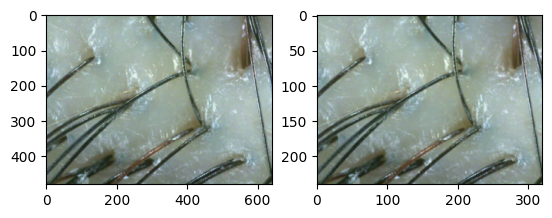

In [8]:
#이미지 리사이징 테스트

test_img_dir='./유형별 두피 이미지/Training/Images/원천_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg'

test_img = Image.open(test_img_dir)
img_resize = test_img.resize((int(test_img.width / 2), int(test_img.height / 2)))

plt.subplot(1,2,1)
plt.imshow(test_img)

plt.subplot(1,2,2)
plt.imshow(img_resize)
plt.show()

100%|██████████| 1370/1370 [00:08<00:00, 170.84it/s]

(64, 64)


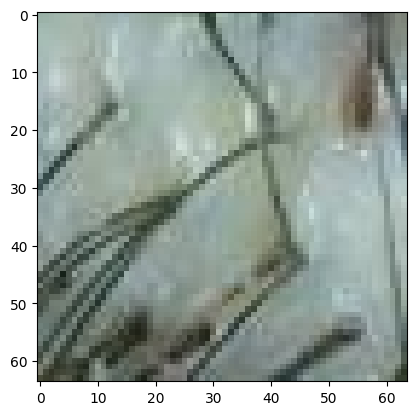

In [9]:
#이미지 리사이징

save_dir='./유형별 두피 이미지/Training/Images_edit'

# for img_file in glob.glob('./유형별 두피 이미지/Training/Images/*'+'/*.*'):
for img_file in tqdm(img_names):

    # print(img_file)

    if not os.path.isdir(img_file[:-44]):   #폴더 경로가 없을 경우
        print('Saving directory:',img_file) #폴더 추가
        os.mkdir(img_file[:-44])

    img_ori = Image.open(img_file)
    # img_resize = img_ori.resize((int(img_ori.width / 2), int(img_ori.height / 2)))
    img_resize = img_ori.resize((64, 64))
    # print(img_resize.size)

    if not os.path.exists(save_dir):
        print('Saving directory:', save_dir)
        os.mkdir(save_dir)

    img_resize.save(save_dir + '/' + img_file[29:-4] + '.jpg', 'JPEG')

test_img = Image.open(save_dir + '/원천_탈모_0.양호/0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg')
print(test_img.size)
plt.imshow(test_img)
plt.show()   #width, height
    

3    836
0    534
Name: value_6, dtype: int64


<AxesSubplot: >

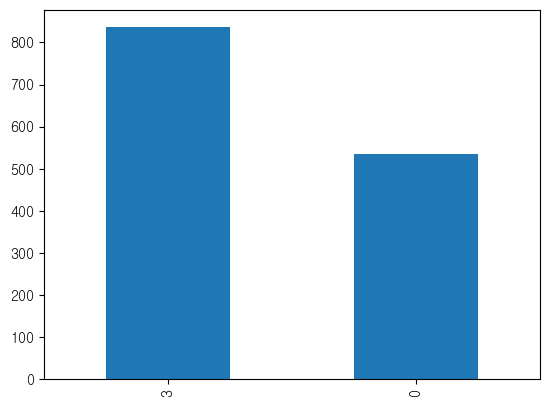

In [10]:
#Visualization by type

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

cnt_by_id=df['value_6'].value_counts()
print(cnt_by_id)    #0 = 정상, 3=탈모
cnt_by_id.plot.bar()

0    534
3    534
Name: value_6, dtype: int64


<AxesSubplot: >

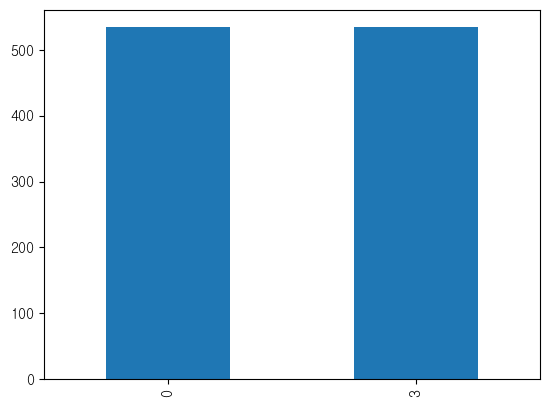

In [11]:
# Undersampling - 데이터 불균형
# They will be randomly sampled to match smaller size.

idx_1 = df[df['value_6'] == 3] #.index
idx_1 = idx_1.sample(n = 302).index
df = df.drop(idx_1)

cnt_by_id=df['value_6'].value_counts()
print(cnt_by_id)
cnt_by_id.plot.bar()

In [12]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import colors
import random
from pathlib import Path
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import cv2

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['value_6'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['value_6'])

print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 683
Test  set rows: 214
Val   set rows: 171


In [58]:
IMAGE_PATH = "./"

def read_image(img_file):
    print('Trained:' , img_file)
    image = skimage.io.imread(IMAGE_PATH+img_file)
    image1 = skimage.transform.resize(image, (64, 64), mode='reflect')
    return image1[:,:,:3]

In [48]:
def categories_encoder(dataset, var='value_6'):
    X = np.stack(dataset['image_dir'].apply(read_image))  #경로
    y = pd.get_dummies(dataset[var], drop_first=False)  #대조군
    return X, y

In [59]:
%%time

X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/3588_A2LEBJJDE00108Y_1604738713417_6_BH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/7988_A2LEBJJDE000357_1604810132301_3_TH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/5569_A2LEBJJDE001211_1606106316403_5_RH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/0888_A2LEBJJDE001948_1604124895777_3_TH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/5644_A2LEBJJDE00198F_1604818370926_2_TH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/2327_A2LEBJJDE00091Y_1605403811551_2_TH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/5644_A2LEBJJDE00198F_1604814752483_5_RH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_3.중증/7027_A2LEBJJDE001117_1603244299021_4_LH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/5750_A2LEBJJDE000589_1604310013872_2_TH.jpg
Trained: ./유형별 두피 이미지/Training/Images_edit/원천_탈모_0.양호/4232_A2LEBJJDE00146O_1604044803128_4_LH.jpg
Trained: ./유형별 두피 이미

In [49]:
model = tf.keras.models.Sequential()
# conv 1
model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu',input_shape=(64,64,3)))
model.add(tf.keras.layers.Dropout(rate=0.5))                          #  DO1
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# conv 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))                          # DO2
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# conv 3
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))                           # DO3
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 dropout_9 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience = 4, verbose=1)

# checkpointer1 = ModelCheckpoint('best_model1.h5'
#                                 ,monitor='val_acc'
#                                 ,verbose=1
#                                 ,save_best_only=True
#                                 ,save_weights_only=True)

train_model1 = model.fit(X_train, y_train, epochs=8,
                            validation_data=(X_val, y_val))

# model.load_weights('best_model1.h5')

Epoch 1/8


ValueError: in user code:

    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 24) are incompatible
